In [1]:
import pandas as pd 
import numpy as np
import os 

from sklearn.model_selection import cross_validate,train_test_split
from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB,MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout, GlobalMaxPooling1D
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;|lt|gt|brgt|ligt|ul|b|p')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../../example/walmartNewData.csv')

In [5]:
df = df[pd.notnull(df['longDescription'])]
df = df[pd.notnull(df['category'])]
df = df[pd.notnull(df['subcategory'])]
df = df[pd.notnull(df['sub2category'])]
df.longDescription = df.longDescription.apply(clean_text)
df.category = df.category.apply(int)
df.subcategory = df.subcategory.apply(int)


df = df[pd.notnull(df['itemId'])]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117423 entries, 0 to 117597
Data columns (total 10 columns):
productName         117416 non-null object
shortDescription    117269 non-null object
longDescription     117423 non-null object
itemId              117423 non-null int64
category            117423 non-null int64
subcategory         117423 non-null int64
sub2category        117423 non-null int64
categoryName        117423 non-null object
subcategoryName     117423 non-null object
sub2categoryName    117423 non-null object
dtypes: int64(4), object(6)
memory usage: 9.9+ MB


In [7]:
le = LabelEncoder()
le.fit(df.category)
target = le.classes_
labels = le.transform(df.category)

le.fit(df.subcategory)
subtarget = le.classes_
sublabels = le.transform(df.subcategory)

In [8]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.longDescription)

In [9]:
K = [2, 3, 4, 5, 10]
testSize = [ 1/ele for ele in K ]
CNBCresults = []
MNBCresults = []
for ele in K:
    MNBC = MultinomialNB()
    CNBC = ComplementNB()
    mnbcresult = cross_validate(MNBC, X, labels, cv=ele , 
                   scoring = ('f1_micro','f1_macro','f1_weighted','accuracy'),return_train_score=True)
    cnbcresult = cross_validate(CNBC, X, labels, cv=ele , 
                   scoring = ('f1_micro','f1_macro','f1_weighted','accuracy'),return_train_score=True)
    CNBCresults.append(cnbcresult)
    MNBCresults.append(mnbcresult)

/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ju

/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ju

In [10]:
SVCresults = []
for ele in K:
    linearsvc = LinearSVC(random_state=42, class_weight="balanced")
    result = cross_validate(linearsvc, X, labels, cv=ele , 
                   scoring = ('f1_micro','f1_macro','f1_weighted','accuracy'),return_train_score=True)
    SVCresults.append(result)
    

/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, i

In [11]:
def result_report(results):
    mean_result_report = []
    for ele in results:
        mean_result = {}
        for key,value in ele.items():
            mean_result[key] = round(np.mean(value),2)
        mean_result_report.append(mean_result)
    return mean_result_report

MNBCReport = result_report(MNBCresults)
CNBCReport = result_report(CNBCresults)
SVCReport = result_report(SVCresults)

In [12]:
MNBCReport,CNBCReport,SVCReport

([{'fit_time': 0.21,
   'score_time': 0.58,
   'test_f1_micro': 0.78,
   'train_f1_micro': 0.82,
   'test_f1_macro': 0.35,
   'train_f1_macro': 0.44,
   'test_f1_weighted': 0.74,
   'train_f1_weighted': 0.79,
   'test_accuracy': 0.78,
   'train_accuracy': 0.82},
  {'fit_time': 0.23,
   'score_time': 0.4,
   'test_f1_micro': 0.8,
   'train_f1_micro': 0.83,
   'test_f1_macro': 0.41,
   'train_f1_macro': 0.47,
   'test_f1_weighted': 0.77,
   'train_f1_weighted': 0.81,
   'test_accuracy': 0.8,
   'train_accuracy': 0.83},
  {'fit_time': 0.27,
   'score_time': 0.29,
   'test_f1_micro': 0.81,
   'train_f1_micro': 0.84,
   'test_f1_macro': 0.43,
   'train_f1_macro': 0.49,
   'test_f1_weighted': 0.78,
   'train_f1_weighted': 0.81,
   'test_accuracy': 0.81,
   'train_accuracy': 0.84},
  {'fit_time': 0.3,
   'score_time': 0.24,
   'test_f1_micro': 0.81,
   'train_f1_micro': 0.84,
   'test_f1_macro': 0.44,
   'train_f1_macro': 0.49,
   'test_f1_weighted': 0.78,
   'train_f1_weighted': 0.82,
   'te

In [13]:
embedding_dim = 300 # We use 100 dimensional glove vectors
glove_dir = '../../glove.6B' # This is the folder with the dataset
embeddings_index = {} # We create a dictionary of word -> embedding
with open(os.path.join(glove_dir, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary
    print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [14]:
def tokenizer_and_pad_sequence (Xtrain,Xtest,vocab_size,embeddings_index):
    tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
    tokenizer.fit_on_texts(Xtrain)
    
    sequences = tokenizer.texts_to_sequences(Xtrain)
    sequences_test = tokenizer.texts_to_sequences(Xtest)
    
    trainlengths = [len(ele) for ele in sequences]
    testlengths = [len(ele) for ele in sequences_test]
    max_length = min(max(trainlengths),max(testlengths))
    
    train = pad_sequences(sequences,maxlen= max_length)
    test = pad_sequences(sequences_test,maxlen = max_length)
    
    word_index = tokenizer.word_index
    embedding_dim = 300
    nb_words = min(vocab_size, len(word_index)) # How many words are there actually
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    # The vectors need to be in the same position as their index. 
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    # Loop over all words in the word index
    for word, i in word_index.items():
        # If we are above the amount of words we want to use we do nothing
        if i >= vocab_size: 
            continue
        # Get the embedding vector for the word
        embedding_vector = embeddings_index.get(word)
        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return train, test, max_length, embedding_matrix

def model_settings(length,vocabSize,embeddingMatrix,outputnum):
        embedding_dim = 300
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Conv1D(200,3,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(GlobalMaxPooling1D())
        # We add a vanilla hidden layer:
        model.add(Dense(250))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        return model

def fit_evaluate(model,Xtrain, ytrain,Xtest,ytest):
    EPOCHS = 10
    BATCH_SIZE = 100
    #set early stopping criteria
    pat = 5 #this is the number of epochs with no improvment after which the training will stop
    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
    result = model.fit(Xtrain, ytrain, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        callbacks=[early_stopping], 
              verbose=1, validation_split=0.1)
    score = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
    return result,score

In [15]:
vocab_size = len(tfidfconverter.get_feature_names())
KFoldTrainResults = []
KFoldTestResults  = []
for i in testSize:
    print("------ "+str(i)+" testing size ------\n")
    Xtrain, Xtest, ytrain , ytest = train_test_split(df['longDescription'].apply(str), labels, test_size= i, random_state = 42)
    categoricalLabel = to_categorical(ytrain)
    categoricalTestLabel = to_categorical(ytest)
    train, test, max_length, embedding_matrix =  tokenizer_and_pad_sequence(Xtrain,Xtest,vocab_size,embeddings_index)
    model = model_settings(max_length,vocab_size,embedding_matrix,len(np.unique(ytrain)))
    result,score = fit_evaluate(model,train,categoricalLabel,test,categoricalTestLabel)
    KFoldTrainResults.append(result)
    KFoldTestResults.append(score)

------ 0.5 testing size ------



W0830 10:29:31.231665 139995631146816 deprecation_wrapper.py:119] From /home/justin/mscproject/app/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 10:29:31.273501 139995631146816 deprecation_wrapper.py:119] From /home/justin/mscproject/app/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 10:29:31.276525 139995631146816 deprecation_wrapper.py:119] From /home/justin/mscproject/app/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 10:29:31.287928 139995631146816 deprecation_wrapper.py:119] From /home/justin/mscproject/app/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.comp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 701, 300)          6878100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 699, 200)          180200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               50250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8032      
Total params: 7,116,582
Trainable params: 238,482
Non-trainable params: 6,878,100
____________________________________________________________

Train on 84544 samples, validate on 9394 samples
Epoch 1/10
84544/84544 [==============================] - 220s 3ms/step - loss: 0.0386 - categorical_accuracy: 0.7869 - val_loss: 0.0297 - val_categorical_accuracy: 0.8380
Epoch 2/10
84544/84544 [==============================] - 211s 2ms/step - loss: 0.0247 - categorical_accuracy: 0.8654 - val_loss: 0.0273 - val_categorical_accuracy: 0.8559
Epoch 3/10
84544/84544 [==============================] - 202s 2ms/step - loss: 0.0199 - categorical_accuracy: 0.8928 - val_loss: 0.0276 - val_categorical_accuracy: 0.8571
Epoch 4/10
84544/84544 [==============================] - 198s 2ms/step - loss: 0.0168 - categorical_accuracy: 0.9113 - val_loss: 0.0299 - val_categorical_accuracy: 0.8553
Epoch 5/10
84544/84544 [==============================] - 207s 2ms/step - loss: 0.0146 - categorical_accuracy: 0.9236 - val_loss: 0.0302 - val_categorical_accuracy: 0.8527
Epoch 6/10
84544/84544 [==============================] - 216s 3ms/step - loss: 0.0128 - ca

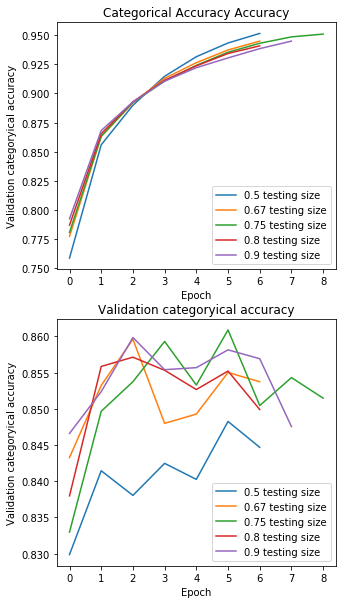

In [16]:
fig, (ax,ax2) = plt.subplots(2, 1,figsize=(5,10))
for ele in KFoldTrainResults:
    currentTestsize = testSize[KFoldTrainResults.index(ele)]
    ax.plot(ele.history['categorical_accuracy'],label= str(round(1-currentTestsize,2))+" testing size")

    ax.legend()
ax.set_title('Categorical Accuracy Accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation categoryical accuracy")

for ele in KFoldTrainResults:
    currentTestsize = testSize[KFoldTrainResults.index(ele)]
    ax2.plot(ele.history['val_categorical_accuracy'],label= str(round(1-currentTestsize,2))+" testing size")
    ax2.legend()
ax2.set_title('Validation categoryical accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation categoryical accuracy")

fig.savefig("WalmartCNNsTrainCrossValidation.png", bbox_inches='tight')

10
3
3
5


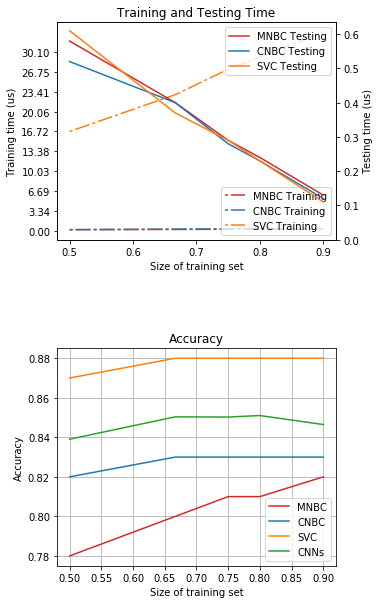

In [17]:
fig, (ax1,ax3) = plt.subplots(2, 1,figsize=(5,10))
fig.subplots_adjust(hspace=0.5)
trainSize = [ (1-1/ele) for ele in K ]
ytrainTimeMNBC = [ ele['fit_time'] for ele in MNBCReport]
ytrainTimeCNBC = [ ele['fit_time'] for ele in CNBCReport]

ytrainTimeSVC = [ ele['fit_time'] for ele in SVCReport]
ytestTimeMNBC = [ ele['score_time'] for ele in MNBCReport]
ytestTimeCNBC = [ ele['score_time'] for ele in CNBCReport]
ytestTimeSVC = [ ele['score_time'] for ele in SVCReport]
yAccCNNs = [ele[1] for ele in KFoldTestResults]
yAccMNBC = [ ele['test_accuracy'] for ele in MNBCReport]
yAccCNBC = [ ele['test_accuracy'] for ele in CNBCReport]
yAccSVC = [ ele['test_accuracy'] for ele in SVCReport]
line1, = ax1.plot(trainSize, ytrainTimeMNBC, color="tab:red", label = "MNBC Training" )
line2, = ax1.plot(trainSize, ytrainTimeCNBC, color="tab:blue", label = "CNBC Training" )
line3, = ax1.plot(trainSize, ytrainTimeSVC, color="tab:orange", label = "SVC Training" )
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break
line2.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break
line3.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

ax1.set_title('Training and Testing Time')
ax1.set_xlabel("Size of training set")
ax1.set_ylabel("Training time (us)")
step1 = (max(ytrainTimeSVC) - min(ytrainTimeSVC))/len(ytrainTimeSVC)
ax1.yaxis.set_ticks(np.arange(0,max(ytrainTimeSVC),step1))
ax1.xaxis.set_ticks(np.arange(0,1,0.1))

# ax1.grid()
ax1.legend(loc=4)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(trainSize, ytestTimeMNBC, color="tab:red", label = "MNBC Testing" )
ax2.plot(trainSize, ytestTimeCNBC, color="tab:blue", label = "CNBC Testing" )
ax2.plot(trainSize, ytestTimeSVC, color="tab:orange", label = "SVC Testing" )
ax2.set_ylabel("Testing time (us)")
step2 = (max(ytestTimeSVC) - min(ytestTimeSVC))/len(ytestTimeSVC)
ax2.yaxis.set_ticks(np.arange(0,max(ytestTimeSVC),step2))
# ax2.grid()
ax2.legend(loc=1)

ax3.plot(trainSize, yAccMNBC, color="tab:red", label = "MNBC" )
ax3.plot(trainSize, yAccCNBC, color="tab:blue", label = "CNBC" )
ax3.plot(trainSize, yAccSVC, color="tab:orange", label = "SVC" )
ax3.plot(trainSize, yAccCNNs, color="tab:green", label = "CNNs" )
ax3.set_title('Accuracy')
ax3.set_xlabel("Size of training set")
ax3.set_ylabel("Accuracy")

ax3.grid()
ax3.legend()

fig.savefig("WalmartCrossValidation.png", bbox_inches='tight')


print(K[np.argmax(yAccMNBC)])
print(K[np.argmax(yAccCNBC)])
print(K[np.argmax(yAccSVC)])
print(K[np.argmax(yAccCNNs)])